In [1]:
import pandas as pd
import nibabel as nib
import glob
import os
import numpy as np
import seaborn as sns
from scipy import spatial, stats
import matplotlib.pyplot as plt
import shap
from radiomics import featureextractor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, r2_score
import xgboost

In [2]:
def load_nib_file(path):
    mask = nib.load(path)
    mask_data = mask.get_fdata()

    return mask, mask_data


def extract_radiomics_features(list_train, path_data, errors, list_test=None, path_data_test=None):
    train_features = {}
    train_shape_features = {}
    if list_test is not None:
        list_to_parse = list_train + list_test
        test_features = {}
        test_shape_features = {}
    else:
        list_to_parse = list_train
    for case in list_to_parse:
        print(case)
        if case in list_train:
            path = path_data
        elif case in list_test:
            path = path_data_test

        image = glob.glob(path + case + '/T1_*_CR_2mm.nii.gz')
        mask = glob.glob(path + case + '/GT_RS_CR_2mm.nii.gz')

        try:
            features = featureextractor.RadiomicsFeatureExtractor()
            features.disableAllFeatures()
            features.enableFeatureClassByName('shape')
            results = features.execute(image[0], mask[0])
            features = {key[15:]: float(results[key]) for key in results.keys() if 'shape' in key}
            if case in list_train:
                train_features.update({case: results})
                train_shape_features.update({case: features})
            elif case in list_test:
                test_features.update({case: results})
                test_shape_features.update({case: features})
        except ValueError as e:
            errors.append(mask)
            result_to_print=re.search('ITK ERROR', format_exc())
            result_to_print_during=re.search('During handling', format_exc())
            print(format_exc()[result_to_print.span()[0]:result_to_print_during.span()[0]])
            
    if list_test is not None:
        return features.keys(), errors, train_features, train_shape_features, test_features, test_shape_features
    else:
        return errors, train_features, train_shape_features

In [3]:
# paths to train and test sets
path_data_baseline_ozgun = "/mnt/data/psteinmetz/neotex/data_MRI/2training_sets_forPCA/"
path_data_MP = "/mnt/data/psteinmetz/neotex/data_MRI/follow_up/Training/"
path_data_MP_test = "/mnt/data/psteinmetz/neotex/data_MRI/follow_up/Testing/"
path_data_baseline_test = "/mnt/data/psteinmetz/neotex/data_MRI/baseline_data/Testing/"
path_data_sheet_MP = "/mnt/data/psteinmetz/neotex/data_MRI/results_Training+Ozgun_test_BDD_25.ods"
path_data_sheet_Baseline = "/mnt/data/psteinmetz/neotex/data_MRI/results_Training+Ozgun+Miparcours_test_BDD_30_2.ods"

In [4]:
# measured perf of algo
scores_MP = pd.read_excel(path_data_sheet_MP, sheet_name="Sheet2", index_col='case')
scores_baseline = pd.read_excel(path_data_sheet_Baseline, sheet_name="Sheet2", index_col='case')

scores = pd.concat((scores_MP, scores_baseline))

# lists of cases
list_training_2sets = [x for x in os.listdir(path_data_baseline_ozgun) if '.' not in x]
list_training_MP = [x for x in os.listdir(path_data_MP) if '.' not in x]
list_testing_MP = [x for x in os.listdir(path_data_MP_test) if '.' not in x]
list_testing_baseline = [x for x in os.listdir(path_data_baseline_test) if '.' not in x]

errors = []

In [5]:
scores

,2trainsets,3trainsets
case,,
case_47_MP,0.000000,0.000000
case_48_MP,0.750654,0.817985
case_49_MP,0.012903,0.370514
case_50_MP,0.000000,0.421242
case_51_MP,0.820170,0.672198
case_52_MP,0.003886,0.641568
case_53_MP,0.839178,0.841722
case_54_MP,0.000000,0.000000
case_56_MP,0.725351,0.755827


In [6]:
# extraction of radiomic features
errors_2sets, train_features_2sets, train_shape_features_2sets = extract_radiomics_features(list_training_2sets, path_data_baseline_ozgun, errors)
errors_testing_baseline, baseline_test_features, baseline_test_shape_features = extract_radiomics_features(list_testing_baseline, path_data_baseline_test, errors)
features, errors_MP, train_features_MP, train_shape_features_MP, test_features, test_shape_features = extract_radiomics_features(list_training_MP, path_data_MP, errors, list_testing_MP, path_data_MP_test)

case_56_Ozgun


case_16_Ozgun
case_1_Ozgun
case_51
case_51_Ozgun
case_116
case_60_Ozgun
case_48_Ozgun
case_7_Ozgun
case_50_Ozgun
case_124
case_22_Ozgun
case_59
case_52
case_36_Ozgun
case_42_Ozgun
case_53
case_25_Ozgun
case_96
case_18_Ozgun
case_130
case_17_Ozgun
case_98
case_13
case_73
case_59_Ozgun
case_61_Ozgun
case_47_Ozgun
case_30
case_5
case_122
case_11_Ozgun
case_93
case_53_Ozgun
case_0
case_37
case_115
case_44
case_100
case_139
case_49_Ozgun
case_62_Ozgun
case_35_Ozgun
case_21
case_128
case_136
case_33
case_5_Ozgun
case_20_Ozgun
case_97
case_95
case_23_Ozgun
case_6
case_135
case_58_Ozgun
case_83
case_125
case_40_Ozgun
case_29_Ozgun
case_28
case_92
case_123
case_111
case_25
case_84
case_41_Ozgun
case_114
case_86
case_99
case_90
case_32_Ozgun
case_79
case_107
case_57_Ozgun
case_4_Ozgun
case_24_Ozgun
case_45
case_133
case_8_Ozgun
case_38
case_141
case_55_Ozgun
case_89
case_104
case_108
case_14_Ozgun
case_12_Ozgun
case_120
case_34_Ozgun
case_119
case_40
case_9_Ozgun
case_134
case_71
case_39_Ozgun
c

In [35]:
#define cases that had a dice > 0.7
scores['state'] = np.where(scores['3trainsets'] >= 0.75, 1, 0)
scores

,2trainsets,3trainsets,state
case,,,
case_47_MP,0.000000,0.000000,0
case_48_MP,0.750654,0.817985,1
case_49_MP,0.012903,0.370514,0
case_50_MP,0.000000,0.421242,0
case_51_MP,0.820170,0.672198,0
case_52_MP,0.003886,0.641568,0
case_53_MP,0.839178,0.841722,1
case_54_MP,0.000000,0.000000,0
case_56_MP,0.725351,0.755827,1


In [36]:
#start with tumor volume
volume_test = pd.concat((pd.DataFrame.from_dict(test_shape_features).T[['MeshVolume', 'SurfaceVolumeRatio']], pd.DataFrame.from_dict(baseline_test_shape_features).T[['MeshVolume', 'SurfaceVolumeRatio']]), axis=0)
volume_train = pd.concat((pd.DataFrame.from_dict(train_shape_features_MP).T[['MeshVolume', 'SurfaceVolumeRatio']], pd.DataFrame.from_dict(train_shape_features_2sets).T[['MeshVolume', 'SurfaceVolumeRatio']]), axis=0)
volumes_logis = pd.concat((scores['state'], volume_test), axis=1)

In [37]:
#start with tumor volume
volume_test_shap = pd.concat((pd.DataFrame.from_dict(test_shape_features).T[['MeshVolume', 'SurfaceVolumeRatio', 'Elongation', 'Sphericity']], pd.DataFrame.from_dict(baseline_test_shape_features).T[['MeshVolume', 'SurfaceVolumeRatio', 'Elongation', 'Sphericity']]), axis=0)
volume_train_shap = pd.concat((pd.DataFrame.from_dict(train_shape_features_MP).T[['MeshVolume', 'SurfaceVolumeRatio', 'Elongation', 'Sphericity']], pd.DataFrame.from_dict(train_shape_features_2sets).T[['MeshVolume', 'SurfaceVolumeRatio', 'Elongation', 'Sphericity']]), axis=0)
volumes_logis_shap = pd.concat((scores['state'], volume_test_shap), axis=1)

In [38]:
volumes_logis_shap

,state,MeshVolume,SurfaceVolumeRatio,Elongation,Sphericity
case_47_MP,0,2909.000000,0.423987,0.554316,0.799007
case_48_MP,1,2210.333333,0.443536,0.838095,0.837020
case_49_MP,0,2261.666667,0.469035,0.707664,0.785481
case_50_MP,0,2779.000000,0.433317,0.704658,0.793808
case_51_MP,0,3341.333333,0.382322,0.738307,0.846086
case_52_MP,0,5424.666667,0.349008,0.714488,0.788603
case_53_MP,1,2906.666667,0.402328,0.802369,0.842246
case_54_MP,0,3379.666667,0.395927,0.613635,0.813913
case_56_MP,1,3658.000000,0.396237,0.770616,0.792103
case_57_MP,0,15883.333333,0.276147,0.692754,0.696676


In [39]:
X, y = np.array(volumes_logis[['MeshVolume', 'SurfaceVolumeRatio']]), np.array(volumes_logis['state'])

In [40]:
clf = LogisticRegression(random_state=0).fit(X, y)

In [41]:
clf.score(X, y)

0.4074074074074074

In [42]:
# Predict probabilities
y_prob = clf.predict_proba(X)[:, 1]
y_pred = clf.predict(X)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y, y_prob)

In [43]:
X_shap, y_shap = volumes_logis_shap.drop("state" ,axis= 1), volumes_logis_shap['state']
background_values = shap.maskers.Independent(X_shap, max_samples=100)

In [44]:
model = LinearRegression()
model.fit(X_shap[['MeshVolume']], scores[['3trainsets']])

LinearRegression()

In [45]:
y_linear_pred = model.predict(X_shap[['MeshVolume']])
r2_score(np.array(scores['3trainsets']), y_linear_pred.ravel())

0.15283871851657205

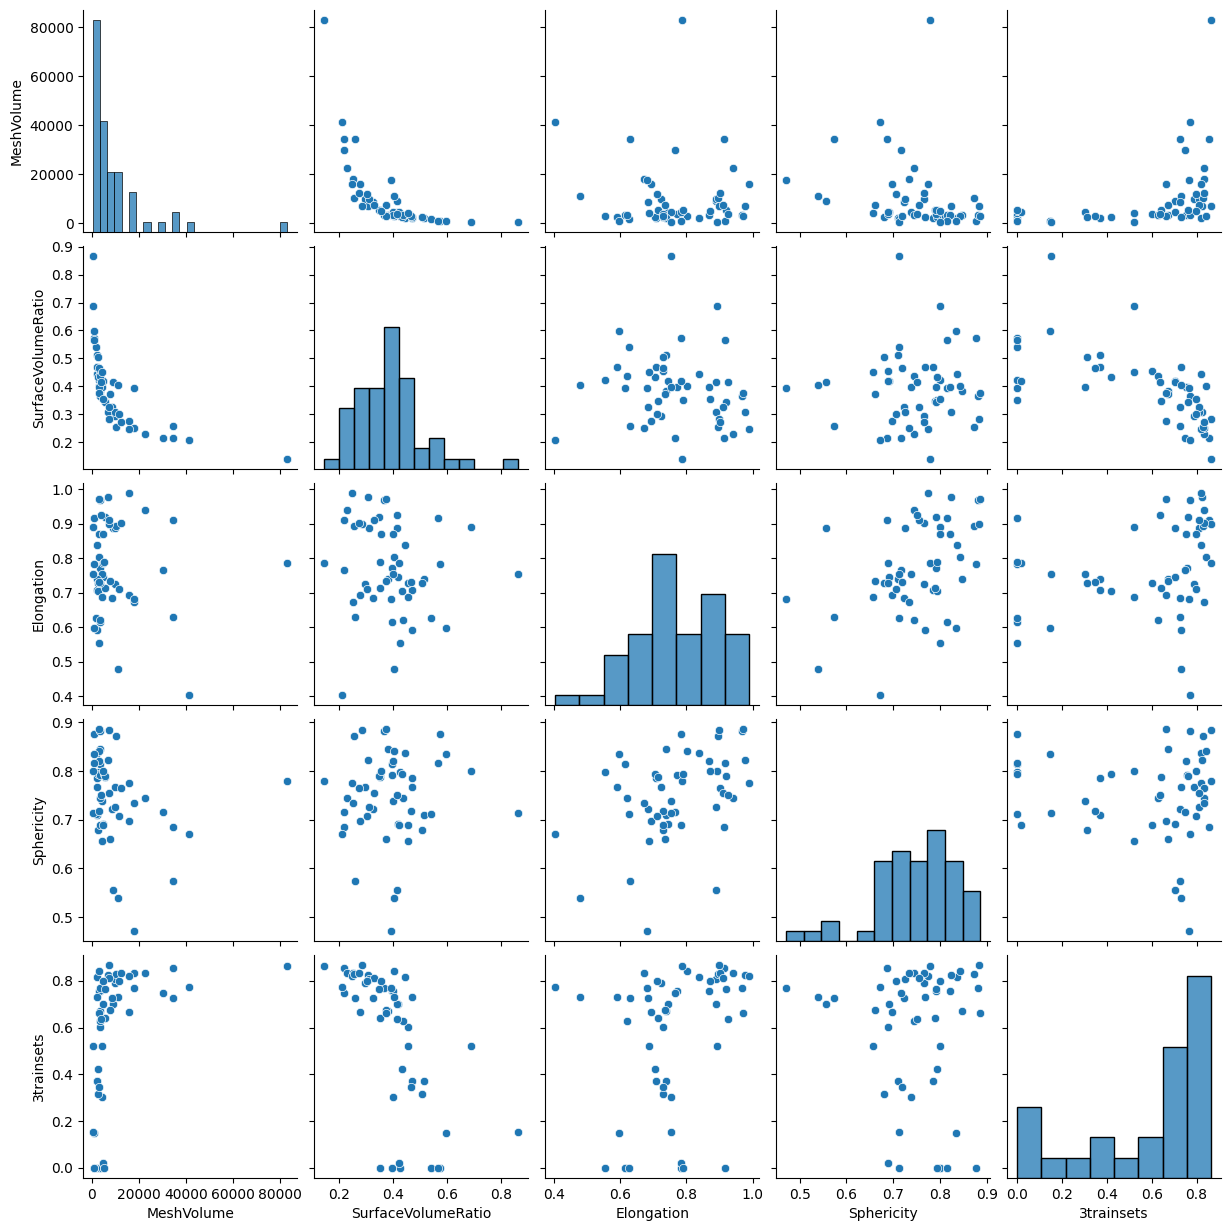

In [46]:
sns.pairplot(pd.concat((X_shap, scores[['3trainsets']])))

In [47]:
np.array(scores['3trainsets'])

array([0.        , 0.81798483, 0.37051432, 0.42124188, 0.67219804,
       0.64156763, 0.84172249, 0.        , 0.75582686, 0.66564417,
       0.78903275, 0.70238924, 0.70230478, 0.82613441, 0.30171023,
       0.37229819, 0.        , 0.        , 0.75440977, 0.31340342,
       0.        , 0.52272727, 0.73048958, 0.14912281, 0.60060643,
       0.01817897, 0.62913822, 0.76976542, 0.73125813, 0.72479241,
       0.85379685, 0.83389793, 0.86414911, 0.74700735, 0.81003177,
       0.83444785, 0.77231839, 0.        , 0.82187252, 0.76361983,
       0.67495425, 0.15367728, 0.82906247, 0.66219546, 0.86594479,
       0.83148414, 0.76759696, 0.34691408, 0.72632146, 0.81191075,
       0.51946324, 0.63593603, 0.79850914, 0.79793328])

In [48]:
y_linear_pred

array([[0.52792603],
       [0.52216362],
       [0.522587  ],
       [0.52685382],
       [0.53149179],
       [0.54867454],
       [0.52790678],
       [0.53180795],
       [0.53410357],
       [0.63493468],
       [0.58509372],
       [0.54255198],
       [0.57943303],
       [0.56171968],
       [0.54043782],
       [0.52328531],
       [0.52017592],
       [0.51126564],
       [0.53065877],
       [0.52680984],
       [0.51332482],
       [0.50952812],
       [0.52365096],
       [0.51150207],
       [0.53445547],
       [0.54256848],
       [0.53116188],
       [0.5320169 ],
       [0.59460609],
       [0.5754054 ],
       [0.78786664],
       [0.68960056],
       [1.18876351],
       [0.75248117],
       [0.58633362],
       [0.65171054],
       [0.84356348],
       [0.54719545],
       [0.63584468],
       [0.54973025],
       [0.56632741],
       [0.50790607],
       [0.58904163],
       [0.52938313],
       [0.56371013],
       [0.60561679],
       [0.65126242],
       [0.528

In [49]:
X_shap['MeshVolume']

case_47_MP      2909.000000
case_48_MP      2210.333333
case_49_MP      2261.666667
case_50_MP      2779.000000
case_51_MP      3341.333333
case_52_MP      5424.666667
case_53_MP      2906.666667
case_54_MP      3379.666667
case_56_MP      3658.000000
case_57_MP     15883.333333
case_58_MP      9840.333333
case_60_MP      4682.333333
case_61_MP      9154.000000
case_63_MP      7006.333333
case_64_MP      4426.000000
case_65_MP      2346.333333
case_66_MP      1969.333333
case_67_MP       889.000000
case_68_MP      3240.333333
case_69_MP      2773.666667
case_83_MP      1138.666667
case_84_MP       678.333333
case_87_MP      2390.666667
case_102_MP      917.666667
case_3          3700.666667
case_4          4684.333333
case_8          3301.333333
case_10         3405.000000
case_11        10993.666667
case_17         8665.666667
case_18        34425.666667
case_19        22511.333333
case_20        83032.666667
case_23        30135.333333
case_26         9990.666667
case_31        17917

In [50]:
y_linear_pred

array([[0.52792603],
       [0.52216362],
       [0.522587  ],
       [0.52685382],
       [0.53149179],
       [0.54867454],
       [0.52790678],
       [0.53180795],
       [0.53410357],
       [0.63493468],
       [0.58509372],
       [0.54255198],
       [0.57943303],
       [0.56171968],
       [0.54043782],
       [0.52328531],
       [0.52017592],
       [0.51126564],
       [0.53065877],
       [0.52680984],
       [0.51332482],
       [0.50952812],
       [0.52365096],
       [0.51150207],
       [0.53445547],
       [0.54256848],
       [0.53116188],
       [0.5320169 ],
       [0.59460609],
       [0.5754054 ],
       [0.78786664],
       [0.68960056],
       [1.18876351],
       [0.75248117],
       [0.58633362],
       [0.65171054],
       [0.84356348],
       [0.54719545],
       [0.63584468],
       [0.54973025],
       [0.56632741],
       [0.50790607],
       [0.58904163],
       [0.52938313],
       [0.56371013],
       [0.60561679],
       [0.65126242],
       [0.528

In [51]:
scores['3trainsets']

case
case_47_MP     0.000000
case_48_MP     0.817985
case_49_MP     0.370514
case_50_MP     0.421242
case_51_MP     0.672198
case_52_MP     0.641568
case_53_MP     0.841722
case_54_MP     0.000000
case_56_MP     0.755827
case_57_MP     0.665644
case_58_MP     0.789033
case_60_MP     0.702389
case_61_MP     0.702305
case_63_MP     0.826134
case_64_MP     0.301710
case_65_MP     0.372298
case_66_MP     0.000000
case_67_MP     0.000000
case_68_MP     0.754410
case_69_MP     0.313403
case_83_MP     0.000000
case_84_MP     0.522727
case_87_MP     0.730490
case_102_MP    0.149123
case_3         0.600606
case_4         0.018179
case_8         0.629138
case_10        0.769765
case_11        0.731258
case_17        0.724792
case_18        0.853797
case_19        0.833898
case_20        0.864149
case_23        0.747007
case_26        0.810032
case_31        0.834448
case_32        0.772318
case_35        0.000000
case_42        0.821873
case_49        0.763620
case_55        0.674954
case_58    

In [52]:
clf_shap = LogisticRegression(random_state=0).fit(X_shap, y_shap)

In [53]:
y_prob_shap = clf_shap.predict_proba(X_shap)[:, 1]

In [54]:
explainer_linear = shap.Explainer(model.predict, background_values)
shap_values_linear = explainer_linear(X_shap)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Elongation
- Sphericity
- SurfaceVolumeRatio



ValueError: X has 4 features, but LinearRegression is expecting 1 features as input.

In [55]:
explainer = shap.Explainer(clf_shap, background_values)
shap_values = explainer(X_shap)

In [56]:
shap.plots.bar(shap_values_linear)

NameError: name 'shap_values_linear' is not defined

In [57]:
shap.plots.beeswarm(shap_values_linear)

NameError: name 'shap_values_linear' is not defined

In [58]:
shap.plots.waterfall(shap_values_linear[6], max_display=16)

NameError: name 'shap_values_linear' is not defined

In [59]:
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(
    X_shap, y_shap * 1, eval_metric="logloss"
)

# compute SHAP values
explainer = shap.Explainer(model, background_values)
shap_values = explainer(X_shap)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
[19:43:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


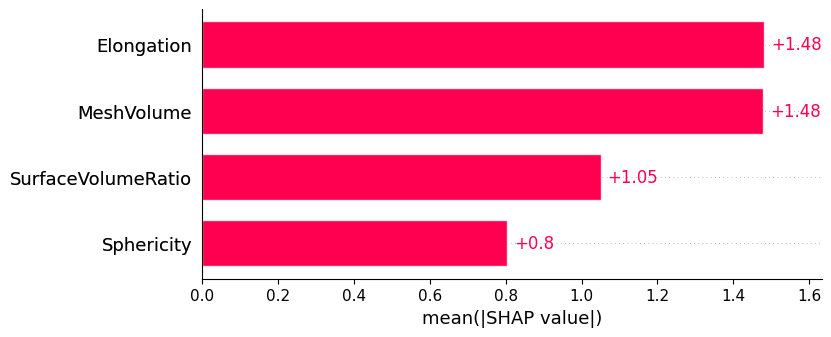

In [60]:
shap.plots.bar(shap_values)



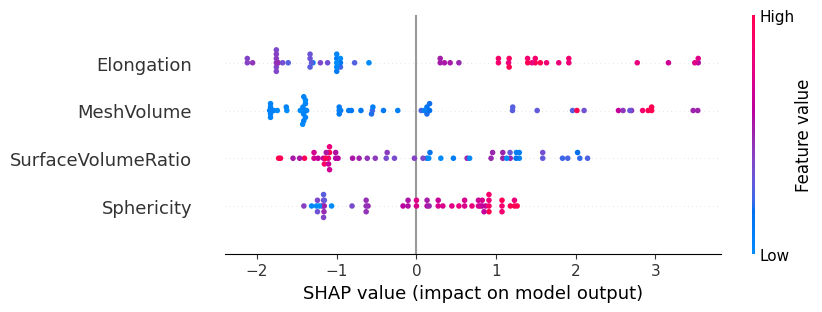

In [61]:
shap.plots.beeswarm(shap_values)